In [1]:
from gaussian_model import CenteredGM
from tqdm import tqdm
import numpy as np
import torch as tch
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from experiment_manager.explorer import get_siblings
import json
%matplotlib inline

N = 50
sigma = np.zeros((N, N))
sigma[0, N - 1] = 1
sigma[N - 1, 0] = 1
for i in range(N - 1):
    sigma[i, i + 1] = 1
    sigma[i + 1, i] = 1
model_to_fit = CenteredGM(N, precision=sigma)

def j_map(c_emp, alpha, gamma, mu=1.):
    return (alpha*c_emp + gamma*mu - np.sqrt((alpha*c_emp - gamma*mu)**2 + 4 * alpha * gamma)) / (2. * gamma)


def rho_averaging(f, alpha, gaussian_model, n_samples=10e3):
    acc = []
    N = gaussian_model.dim
    for plop in range(int(n_samples // N)):
        spectrum, _ = tch.symeig(tch.from_numpy(model_to_fit.get_empirical_C(alpha * N)), eigenvectors=False)
        acc.extend(f(spectrum.cpu().numpy()))
    return np.mean(acc)

Preparing output folders
precision matrix :  [[10.17392796  5.0616557   0.         ...  0.          0.
   5.0616557 ]
 [ 5.0616557  10.17392796  5.0616557  ...  0.          0.
   0.        ]
 [ 0.          5.0616557  10.17392796 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 10.17392796  5.0616557
   0.        ]
 [ 0.          0.          0.         ...  5.0616557  10.17392796
   5.0616557 ]
 [ 5.0616557   0.          0.         ...  0.          5.0616557
  10.17392796]] 





covariance matrix :  [[ 1.         -0.90621809  0.82149837 ... -0.74499363  0.82149837
  -0.90621809]
 [-0.90621809  1.         -0.90621809 ...  0.67593882 -0.74499363
   0.82149837]
 [ 0.82149837 -0.90621809  1.         ... -0.6136434   0.67593882
  -0.74499363]
 ...
 [-0.74499363  0.67593882 -0.6136434  ...  1.         -0.90621809
   0.82149837]
 [ 0.82149837 -0.74499363  0.67593882 ... -0.90621809  1.
  -0.90621809]
 [-0.90621809  0.82149837 -0.74499363 ...  0.82149837 -0.906

In [2]:
def solve_mu(gaussian_model, alpha, gamma, n_samples=1e4, _debug=True):
    avg = lambda func: rho_averaging(func, alpha, gaussian_model, n_samples=n_samples)
    
    # Because of the theoretical formula, we know that the mu normalization integral varies in 
    # 1 pm gamma / alpha -> impossible to solve numerically, too much uncertainty
    if gamma / alpha < 5e-2:
        return avg(lambda c: 1./c)
    
    mu_min = 0.98
    mu_max = rho_averaging(lambda C: 1./C, alpha, gaussian_model) 
    j_star = lambda C, mu: j_map(C, alpha, gamma, mu=mu)
    
    def surrogate(mu):
        plop = lambda C: 1. / (mu - j_star(C, mu))
        return 1. - avg(plop)
    
    # This to avoid issues when gamma too large, mu gets too close to 1
    if gamma / alpha > 1e2:
        try :
            roots = brentq(surrogate, mu_min, mu_max)
        except ValueError:
            return 1.
        
    # Regular pathways
    else :
        roots = brentq(surrogate, mu_min, mu_max)
    
    return roots

def plot_mu_gamma(gaussian_model, alpha, gamma_range, n_samples=1e4):
    mus = []
    for gamma in tqdm(gamma_range, leave=False):
        mus.append(solve_mu(gaussian_model, alpha, gamma))
    plt.figure()
    plt.semilogx(gamma_range, mus)
    plt.show()
    return mus

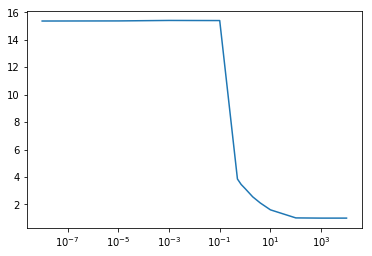

[15.378122159783828,
 15.385673500420348,
 15.42041819764033,
 15.415527622040978,
 15.411871358639422,
 3.854586532281409,
 3.4563302853925957,
 3.1579630314641776,
 2.553268537872216,
 2.101111981569589,
 1.6034849614408868,
 1.015261881336368,
 1.0000912766083494,
 1.0000013656156779]

In [3]:
plot_mu_gamma(model_to_fit, 3., [1e-8, 1e-5, 1e-3, 1e-2, 0.1, 0.5, 0.7, 1, 2., 4., 10, 100, 1000, 10000])

In [3]:
def compute_L_test(alpha, gaussian_model, j_map_func, n_samples=10e3):
    acc = []
    N = gaussian_model.dim
    ref_spectrum = tch.symeig(tch.from_numpy(model_to_fit.covariance), eigenvectors=False)[0].cpu().numpy()

    for plop in range(int(n_samples // N)):
        spectrum, _ = tch.symeig(tch.from_numpy(model_to_fit.get_empirical_C(alpha * N)), eigenvectors=False)
        acc.extend(j_map_func(spectrum.cpu().numpy()) * ref_spectrum)
    return np.mean(acc)

def compute_likelihoods(gaussian_model, alpha, gamma, n_samples=10e3, _debug=False):
    # Seems like the issue is coming from Q2 -> if we hardcode it to the experimental value, 
    # everything works fine
    N = gaussian_model.dim
    mu = solve_mu(gaussian_model, alpha, gamma, _debug=_debug)
    
    j_star = lambda C: j_map(C, alpha, gamma, mu=mu)
    avg = lambda func: rho_averaging(func, alpha, gaussian_model, n_samples=n_samples)
    
    c_times_jc = lambda C: C * j_star(C)
    jc_square = lambda C: j_star(C) * j_star(C)
    log_mu_minus_j = lambda C: np.log(mu - j_star(C))
    
    # This seems to be true
    logZ = N / 2. * (mu - avg(log_mu_minus_j))
    
    # Not this
    q2 = avg(jc_square) * N / 2.

    # this would be true exccept for fucking Q2
    L_test = N / 2. * compute_L_test(alpha, gaussian_model, j_star) 
    L_train = N / 2. * avg(c_times_jc)
    L_gen = L_train - (gamma/alpha) * q2 
    
    if _debug:
        print('mu = {}'.format(mu))
        print('logZ = {}'.format(logZ))
        print('Ltrain {}, q2 {}, Lgen {}'.format(L_train, q2, L_gen))
    
    return L_train, L_test, L_gen, logZ, q2
    

In [13]:
def plot_likelihoods(n_samples=1e5, path='out_bidiag/', base_exp='23e22032399e1336', n_l=0, n_r=0):
    siblings, values = get_siblings(base_exp, 'gamma', path=path)
    plop = len(values)
    siblings, values = siblings[n_l:plop-n_r], values[n_l:plop-n_r]

#     gamma_min, gamma_max = values[0], values[-1]
#     gamma_range = np.exp(np.linspace(np.log(gamma_min), np.log(gamma_max), 20.))
    
    with open(path+'raw/{}/params'.format(base_exp), 'r') as f:
        alpha = json.load(f)['alpha']
    
    gamma_values = values
    
    th_acc = np.zeros((5, len(gamma_values)))
    
    L_train_mean = np.zeros(len(gamma_values))
    L_train_std = np.zeros(len(gamma_values))
    
    L_test_mean = np.zeros(len(gamma_values))
    L_test_std = np.zeros(len(gamma_values))
    
    L_gen_mean = np.zeros(len(gamma_values))
    L_gen_std = np.zeros(len(gamma_values))
    
    logZ_mean = np.zeros(len(gamma_values))
    logZ_mean_th = np.zeros(len(gamma_values))
    
    Q2_mean = np.zeros(len(gamma_values))
    Q2_std = np.zeros(len(gamma_values))
    
    for idx, gamma in enumerate(tqdm(gamma_values)):
        L_train_mean[idx] = np.load(path+'raw/{}/L_train.npy'.format(siblings[idx]))[:, -100:].mean()
        L_train_std[idx] = np.load(path+'raw/{}/L_train.npy'.format(siblings[idx]))[:, -100:].std()
        
        L_test_mean[idx] = np.load(path+'raw/{}/L_test.npy'.format(siblings[idx]))[:, -100:].mean()
        L_test_std[idx] = np.load(path+'raw/{}/L_test.npy'.format(siblings[idx]))[:, -100:].std()
        
        L_gen_mean[idx] = np.load(path+'raw/{}/L_gen.npy'.format(siblings[idx]))[:, -100:].mean()
        L_gen_std[idx] = np.load(path+'raw/{}/L_gen.npy'.format(siblings[idx]))[:, -100:].std()
        
        logZ_mean[idx] = np.load(path+'raw/{}/logZ.npy'.format(siblings[idx]))[:, -100:].mean()
        
        Q2_mean[idx] = np.load(path+'raw/{}/Q2.npy'.format(siblings[idx]))[:, -100:].mean()
        Q2_std[idx] = np.load(path+'raw/{}/Q2.npy'.format(siblings[idx]))[:, -100:].std()
        
        th_acc[:, idx] = np.array(compute_likelihoods(model_to_fit, alpha, gamma, n_samples=n_samples, _debug=True))
        logZ_mean_th[idx] = th_acc[3, idx]
        
    plt.figure()
    plt.title(r'Likelihoods as a function of $\gamma$ for $alpha$={}'.format(alpha))
    plt.plot(gamma_values, th_acc[0, :] - th_acc[3, :], c='b', label=r'$L^{train} th$')
    plt.plot(gamma_values, th_acc[1, :] - th_acc[3, :], c='r', label=r'$L^{test} th$')
    plt.plot(gamma_values, th_acc[2, :] - th_acc[3, :], c='g', label=r'$L^{gen}th$')
    plt.xscale('log')
    plt.show()
    
    lims = [np.min([np.min(th_acc[0, :] - th_acc[3, :]), np.min(th_acc[1, :] - th_acc[3, :]), np.min(th_acc[2, :] - th_acc[3, :])]),
           np.max([np.max(th_acc[0, :] - th_acc[3, :]), np.max(th_acc[1, :] - th_acc[3, :]), np.max(th_acc[2, :] - th_acc[3, :])])]
    
    lims = 1.3 * np.array(lims)
    
    plt.figure()
    plt.errorbar(gamma_values, np.clip(L_train_mean - logZ_mean_th, *lims), yerr=L_train_std, fmt='o', c='b', label=r'$L^{train} exp$')
    plt.errorbar(gamma_values, np.clip(L_test_mean - logZ_mean_th, *lims), yerr=L_test_std, fmt='o', c='r', label=r'$L^{test} exp$')
    plt.errorbar(gamma_values, np.clip(L_gen_mean - logZ_mean_th, *lims), yerr=L_gen_std, fmt='o', c='g', label=r'$L^{gen} exp$')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel('Log likelihoods')
    plt.xscale('log')

    plt.ylim(lims)
    plt.legend(loc='best')
    plt.show()
    
    plt.figure()
    plt.title(r'Likelihoods as a function of $\gamma$ for $alpha$={}'.format(alpha))
    plt.plot(gamma_values, th_acc[0, :] - th_acc[3, :], c='b', label=r'$L^{train} th$')
    plt.plot(gamma_values, th_acc[1, :] - th_acc[3, :], c='r', label=r'$L^{test} th$')
    plt.plot(gamma_values, th_acc[2, :] - th_acc[3, :], c='g', label=r'$L^{gen}th$')
    plt.errorbar(gamma_values, np.clip(L_train_mean - logZ_mean_th, *lims), yerr=L_train_std, fmt='o', c='b', label=r'$L^{train} exp$')
    plt.errorbar(gamma_values, np.clip(L_test_mean - logZ_mean_th, *lims), yerr=L_test_std, fmt='o', c='r', label=r'$L^{test} exp$')
    plt.errorbar(gamma_values, np.clip(L_gen_mean - logZ_mean_th, *lims), yerr=L_gen_std, fmt='o', c='g', label=r'$L^{gen} exp$')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel('Log likelihoods')
    plt.xscale('log')
    plt.ylim(lims)
    plt.legend(loc='best')
    plt.show()
    
    
    plt.figure()
    plt.title(r'Q2 as a function of $\gamma$ for $alpha$={}'.format(alpha))
    plt.errorbar(gamma_values, Q2_mean, yerr=Q2_std, fmt='o', c='b', label=r'$Q2 exp$')
    plt.plot(gamma_values, th_acc[-1])
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    
    
    plt.figure()
    plt.plot(gamma_values, (th_acc[2, :]-th_acc[1, :]) / (th_acc[0, :]-th_acc[1, :]), c='b', label=r'$\frac{L^{gen}-L^{test}}{L^{train}-L^{test}}$')
#     plt.plot(gamma_values, (L_gen_mean - L_test_mean))
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel('Likelihood ratio')
    plt.xscale('log')
    plt.legend(loc='best')
    plt.show()
    


  0%|          | 0/17 [00:00<?, ?it/s]

To vary parameter gamma in [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 3.e-01 7.e-01 1.e+00
 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07], visit ['6b8f88f2552a1bb3' 'd0288d6fab5586cd' '23e22032399e1336'
 'e0a855415d63c453' '4a57676558ec098b' '3c19b8c43e005077'
 'b0cd83158b28861f' '78ab226bb5063c07' '01835c26d372ce1c'
 '40f52006a16183cd' 'c14e7f3aaa7f1818' '952563c3149563e9'
 '738468ba294108e9' '4501081cfcd562c3' '364b9bc07a0651fc'
 'ab0d01aecaf3c0eb' '01fee0fbe0cab64d']



  6%|▌         | 1/17 [00:10<02:53, 10.83s/it]

mu = 15.448786845918134
logZ = 338.346031955517
Ltrain 360.78651879283916, q2 6055.618657039104, Lgen 360.78631693888394



 12%|█▏        | 2/17 [00:22<02:44, 10.97s/it]

mu = 15.439728963412744
logZ = 338.1228927341149
Ltrain 361.1299540263801, q2 6064.831060655837, Lgen 361.12793241602657



 18%|█▊        | 3/17 [00:34<02:39, 11.38s/it]

mu = 15.435106090739762
logZ = 338.03740820304523
Ltrain 361.58482261762686, q2 5991.52188908263, Lgen 361.5648508779966



 24%|██▎       | 4/17 [00:46<02:30, 11.58s/it]

mu = 15.343493782606997
logZ = 335.90701903617673
Ltrain 359.07314486106105, q2 5432.677141237704, Lgen 358.8920556230198



 29%|██▉       | 5/17 [00:58<02:20, 11.72s/it]

mu = 15.434857573017842
logZ = 339.0799264442604
Ltrain 361.1382501803627, q2 3523.838553932656, Lgen 359.96363732905183



 35%|███▌      | 6/17 [01:10<02:10, 11.87s/it]

mu = 15.400780207349806
logZ = 339.3701815344673
Ltrain 361.66490514989044, q2 1926.1532749760597, Lgen 355.2443942333036



 41%|████      | 7/17 [01:22<01:59, 11.91s/it]

mu = 15.414292592178967
logZ = 334.7083163358502
Ltrain 350.6966361489947, q2 1141.0185139391672, Lgen 312.6626856843558



 47%|████▋     | 8/17 [01:50<02:29, 16.65s/it]

mu = 4.347502898192048
logZ = 79.00623281441652
Ltrain 92.44752231677073, q2 85.6402091938467, Lgen 83.88350139738606



 53%|█████▎    | 9/17 [02:14<02:30, 18.87s/it]

mu = 3.453522937091303
logZ = 61.04914320533135
Ltrain 71.06874709613356, q2 41.765521616919, Lgen 61.323458718852464



 59%|█████▉    | 10/17 [02:37<02:21, 20.22s/it]

mu = 3.12472226648506
logZ = 54.793866298489405
Ltrain 63.51832842932822, q2 30.606508157239382, Lgen 53.31615904358176



 65%|██████▍   | 11/17 [03:00<02:05, 20.95s/it]

mu = 1.6008183562352702
logZ = 30.389473926547534
Ltrain 26.922352416054846, q2 3.575940847299534, Lgen 15.002549591723065



 71%|███████   | 12/17 [03:21<01:44, 20.88s/it]

mu = 1.0149199045785302
logZ = 25.148807731683092
Ltrain 7.08250038482922, q2 0.20125093291877222, Lgen 0.3741359542034788



 76%|███████▋  | 13/17 [03:44<01:26, 21.55s/it]

mu = 1.000092139487859
logZ = 25.001119371778774
Ltrain 0.7449176858530185, q2 0.002232602784080344, Lgen 0.0007167578262372576



 82%|████████▏ | 14/17 [04:06<01:04, 21.65s/it]

mu = 1.0000012402660916
logZ = 25.0000172311522
Ltrain 0.07462272528873547, q2 2.2468789757533902e-05, Lgen -0.00027324056971086974



 88%|████████▊ | 15/17 [04:23<00:40, 20.37s/it]

mu = 1.0000000371374034
logZ = 24.9999993168651
Ltrain 0.007466881546281381, q2 2.2499065973739574e-07, Lgen -3.2807111631810715e-05



 94%|█████████▍| 16/17 [04:42<00:19, 19.78s/it]

mu = 0.9999999884434347
logZ = 25.000000056853857
Ltrain 0.0007499760839049913, q2 2.249267092194844e-09, Lgen 2.2038650670998684e-07



100%|██████████| 17/17 [04:59<00:00, 19.22s/it]


mu = 0.9999999999760734
logZ = 24.99999999662626
Ltrain 7.469441055300406e-05, q2 2.243899044129986e-11, Lgen -1.0222425132881696e-07


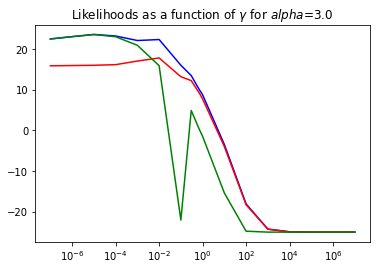

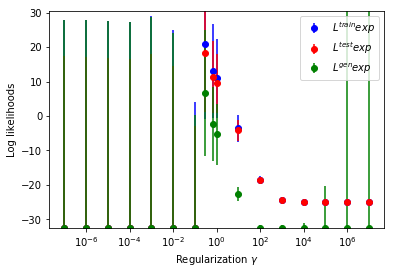

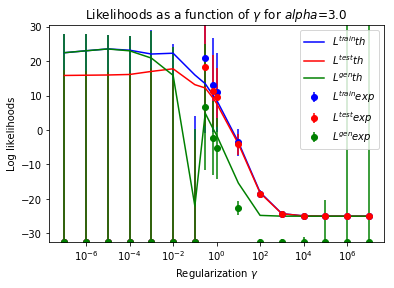

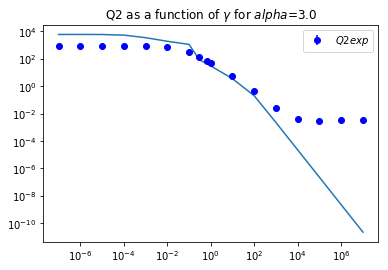

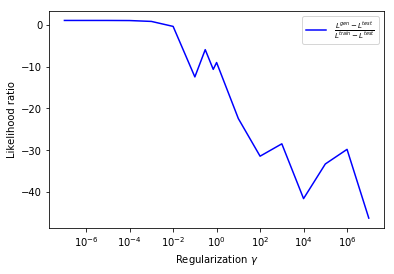

In [16]:
plot_likelihoods(n_l=0, n_r=0)


  0%|          | 0/17 [00:00<?, ?it/s]

To vary parameter gamma in [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 3.e-01 7.e-01 1.e+00
 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07], visit ['3cd7e36741af1977' '4e3bdefbe6077f0b' '1d68cb23831db600'
 '6f99e408be723a63' 'e64bc954342a0ba2' '1d12e0b1954ef60a'
 'f10f68f932c4c711' '7726e93c16cdba86' 'fe912345062f48a5'
 '10cf9482fe70cf18' 'e5e97f25f949049b' '632755cd9a966c7a'
 'abbfac1eced955cf' '85fa9ea7b65ad97b' '048426a088a62f43'
 '902b9080c43f4b50' 'ff3fe79eb525adce']



  6%|▌         | 1/17 [00:17<04:35, 17.21s/it]

mu = 11.321658975017423
logZ = 238.69141703674103
Ltrain 257.92258660218266, q2 1956.8643658979986, Lgen 257.922567033539



 12%|█▏        | 2/17 [00:35<04:25, 17.67s/it]

mu = 11.326709651629741
logZ = 238.80903290176474
Ltrain 258.5184513589517, q2 1958.7807765440712, Lgen 258.5182554808741



 18%|█▊        | 3/17 [00:55<04:15, 18.27s/it]

mu = 11.327018299172703
logZ = 238.82366576414844
Ltrain 258.4665735691708, q2 1958.79689527416, Lgen 258.4646147722755



 24%|██▎       | 4/17 [01:14<03:58, 18.33s/it]

mu = 11.342510935368377
logZ = 239.22368285615593
Ltrain 258.91254338913166, q2 1938.9829661753292, Lgen 258.8931535594699



 29%|██▉       | 5/17 [01:31<03:36, 18.08s/it]

mu = 11.342644225576656
logZ = 239.39624010935088
Ltrain 258.8347545697736, q2 1831.5977912464039, Lgen 258.65159479064897



 35%|███▌      | 6/17 [01:48<03:15, 17.77s/it]

mu = 11.31988332869676
logZ = 239.7760154665299
Ltrain 258.9950986964044, q2 1328.3241881272834, Lgen 257.6667745082771



 41%|████      | 7/17 [02:06<02:56, 17.66s/it]

mu = 11.319357361470617
logZ = 240.68181273791316
Ltrain 259.11303275747497, q2 804.2271775169477, Lgen 251.0707609823055



 47%|████▋     | 8/17 [02:21<02:33, 17.10s/it]

mu = 11.333617221117269
logZ = 239.41525425957872
Ltrain 256.06879636907263, q2 639.7840190363744, Lgen 236.8752757979814



 53%|█████▎    | 9/17 [03:08<03:26, 25.87s/it]

mu = 4.738111409946594
logZ = 87.37799476066364
Ltrain 101.064775141855, q2 109.25229346358883, Lgen 93.41711459940377



 59%|█████▉    | 10/17 [03:43<03:21, 28.79s/it]

mu = 4.303317789683704
logZ = 78.24177592945314
Ltrain 90.67731598732264, q2 81.89096837307758, Lgen 82.48821915001488



 65%|██████▍   | 11/17 [04:17<03:00, 30.16s/it]

mu = 2.2398447760288343
logZ = 39.39604607881988
Ltrain 42.07630358907748, q2 10.977333792088663, Lgen 31.09896979698882



 71%|███████   | 12/17 [04:58<02:48, 33.67s/it]

mu = 1.2012313539641324
logZ = 26.418771785398455
Ltrain 15.832600254625548, q2 1.0804399254822652, Lgen 5.0282009998028965



 76%|███████▋  | 13/17 [05:35<02:17, 34.43s/it]

mu = 1.0011402128781208
logZ = 25.013275522062184
Ltrain 2.390054375383362, q2 0.023648329180176043, Lgen 0.025221457365757427



 82%|████████▏ | 14/17 [06:12<01:45, 35.25s/it]

mu = 1.0000093177856562
logZ = 25.000113350616914
Ltrain 0.24298010363487596, q2 0.0002430609392993615, Lgen -8.083566448555124e-05



 88%|████████▊ | 15/17 [06:48<01:10, 35.43s/it]

mu = 1.000000223701616
logZ = 25.000001085253565
Ltrain 0.02418234579449721, q2 2.4236182234824277e-06, Lgen -5.3836440327068025e-05



 94%|█████████▍| 16/17 [07:19<00:34, 34.28s/it]

mu = 1.0000000105107334
logZ = 24.99999973405753
Ltrain 0.0024252727185373837, q2 2.41851345194649e-08, Lgen 6.759266590893737e-06



100%|██████████| 17/17 [07:49<00:00, 32.84s/it]


mu = 1.0000000008025018
logZ = 25.000000012735057
Ltrain 0.0002417480554740041, q2 2.420275860767769e-10, Lgen -2.795306027728213e-07


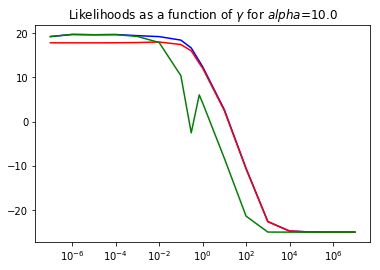

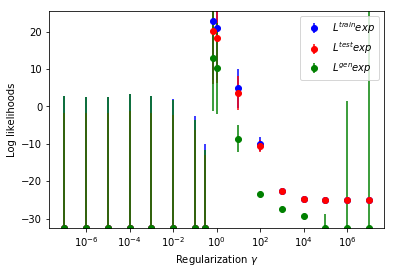

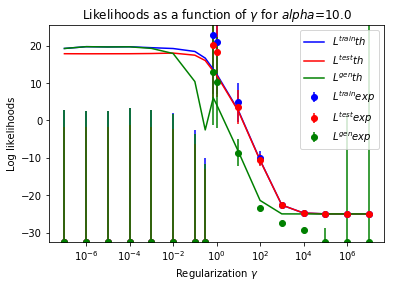

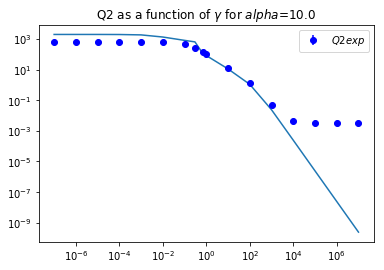

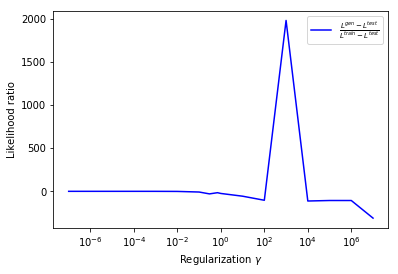

In [18]:
plot_likelihoods(base_exp='e5e97f25f949049b', n_l=0, n_r=0)


  0%|          | 0/17 [00:00<?, ?it/s]

To vary parameter gamma in [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 3.e-01 7.e-01 1.e+00
 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07], visit ['bfa019f0cd920841' 'fe93592cba2610fb' '1eeb2263ffcfd24c'
 'c8f289763b830973' '618f7d4bdc8335c5' '03e6672b7a06b299'
 'b1f02f7329e72ad5' '762a87ccd8d70e8f' '8116c47e2159e291'
 'dce4a5897aac157f' 'e4b1122605c37c42' '4491a251718f6a28'
 '2c275ac2e9ed7d4e' '35097bc7c4025ec3' 'a60d9cefa7f14a2c'
 '43ecf3a05c531050' 'ab56d0c0649927e3']



  6%|▌         | 1/17 [00:29<07:46, 29.13s/it]

mu = 10.721066954841925
logZ = 224.33711858727446
Ltrain 242.8573790747123, q2 1579.1803091358024, Lgen 242.85737117881075



 12%|█▏        | 2/17 [00:57<07:11, 28.76s/it]

mu = 10.723423520980154
logZ = 224.40680762973622
Ltrain 243.1197189265166, q2 1577.5677640742535, Lgen 243.11964004812842



 18%|█▊        | 3/17 [01:26<06:47, 29.11s/it]

mu = 10.714857695270938
logZ = 224.19831279994895
Ltrain 242.80876587996616, q2 1578.3359961027172, Lgen 242.8079767119681



 24%|██▎       | 4/17 [01:55<06:17, 29.07s/it]

mu = 10.713805208690886
logZ = 224.1623243486869
Ltrain 242.88284407952912, q2 1574.454443852984, Lgen 242.87497180730986



 29%|██▉       | 5/17 [02:21<05:37, 28.10s/it]

mu = 10.721634545131849
logZ = 224.43922150230406
Ltrain 242.94795768653873, q2 1538.944035039895, Lgen 242.87101048478672



 35%|███▌      | 6/17 [02:50<05:11, 28.35s/it]

mu = 10.724492898543971
logZ = 225.03667319990797
Ltrain 243.61984262535978, q2 1302.0643027174865, Lgen 242.96881047400103



 41%|████      | 7/17 [03:18<04:40, 28.09s/it]

mu = 10.722141776195384
logZ = 226.4274267573977
Ltrain 244.5282859972413, q2 820.2112071445729, Lgen 240.42722996151844



 47%|████▋     | 8/17 [03:45<04:10, 27.84s/it]

mu = 10.721380151875492
logZ = 226.2033276738553
Ltrain 243.72455961877358, q2 660.7262599893849, Lgen 233.8136657189328



 53%|█████▎    | 9/17 [04:13<03:43, 27.89s/it]

mu = 10.715069638586066
logZ = 224.66598842757915
Ltrain 240.93694069521828, q2 549.192810142691, Lgen 221.7151923402241



 59%|█████▉    | 10/17 [05:01<03:57, 33.88s/it]

mu = 5.0711112567382886
logZ = 94.4560557409335
Ltrain 108.68843155828165, q2 137.51499767192638, Lgen 101.81268167468534



 65%|██████▍   | 11/17 [05:48<03:46, 37.80s/it]

mu = 2.737094453017096
logZ = 47.78381379628105
Ltrain 53.73469740443455, q2 20.563725373126456, Lgen 43.45283471787132



 71%|███████   | 12/17 [06:26<03:09, 37.84s/it]

mu = 1.4121139307551391
logZ = 28.31459684323257
Ltrain 21.96771116503989, q2 2.312265636406964, Lgen 10.40638298300507



 76%|███████▋  | 13/17 [07:09<02:37, 39.35s/it]

mu = 1.005197517092193
logZ = 25.057355062920255
Ltrain 4.682590944192444, q2 0.09098363808066189, Lgen 0.13340904015934907



 82%|████████▏ | 14/17 [07:56<02:05, 41.92s/it]

mu = 1.000040009694578
logZ = 25.00049894344559
Ltrain 0.47866010151883115, q2 0.0009589192208874777, Lgen -0.0007995089249077103



 88%|████████▊ | 15/17 [08:36<01:22, 41.08s/it]

mu = 1.000000377679223
logZ = 25.000005728333708
Ltrain 0.04808969687303013, q2 9.625132397197604e-06, Lgen -3.5965112957891954e-05



 94%|█████████▍| 16/17 [09:17<00:41, 41.20s/it]

mu = 0.9999999957450781
logZ = 24.99999972889913
Ltrain 0.004807729139249901, q2 9.630067276408394e-08, Lgen -7.3044989542959265e-06



100%|██████████| 17/17 [09:59<00:00, 41.52s/it]


mu = 1.0000000015457675
logZ = 25.000000026623432
Ltrain 0.00048172204327859167, q2 9.641221513004673e-10, Lgen -3.3903237164201313e-07


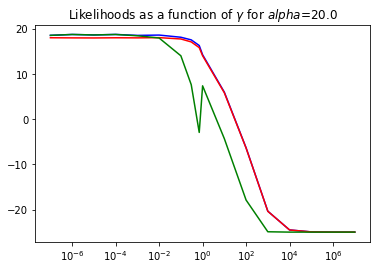

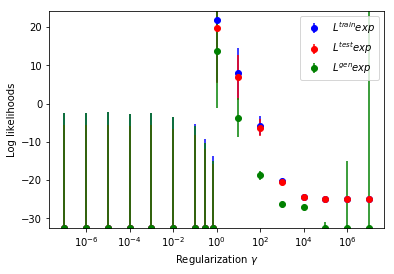

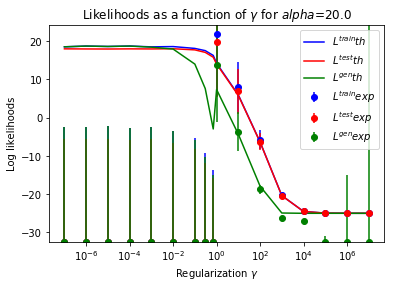

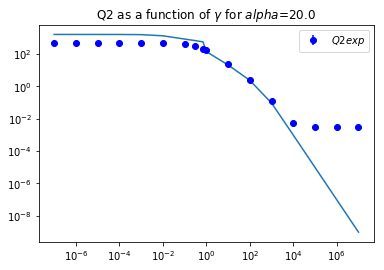

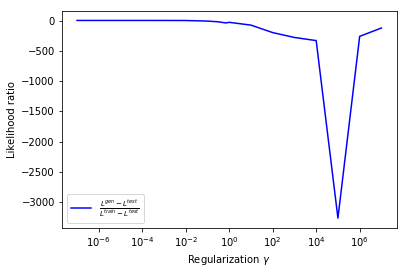

In [17]:
plot_likelihoods(base_exp='4491a251718f6a28', n_l=0, n_r=0)


  0%|          | 0/17 [00:00<?, ?it/s]

To vary parameter gamma in [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 3.e-01 7.e-01 1.e+00
 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07], visit ['1863b4bf2a757419' '3ea67eb68451c5d6' 'f2c5d28de9f9ab63'
 'aeb482616e697bc6' '670e5f3638e26339' '5d2b20b7a6a0c49e'
 '422eca2201340a0a' 'c59772b5cc8759b6' 'b1d15ef1b6f53c9e'
 '9b2857df278606a9' '81382151f799f093' 'c29f0d2995d8b769'
 '21ec5ca199e23954' '39eaddb08fbb7fe0' '85936fe1c21ae59e'
 '1a8363609b8d8d01' '176492489e216d96']



  6%|▌         | 1/17 [01:41<27:07, 101.72s/it]

mu = 10.277176299022148
logZ = 213.7661065891542
Ltrain 231.92531705796645, q2 1335.5602044171565, Lgen 231.92531572240625



 12%|█▏        | 2/17 [03:30<25:58, 103.87s/it]

mu = 10.280897571995132
logZ = 213.85973569024173
Ltrain 232.0475142953439, q2 1334.940090569772, Lgen 232.04750094594297



 18%|█▊        | 3/17 [05:07<23:45, 101.83s/it]

mu = 10.280324861292724
logZ = 213.84658854785843
Ltrain 232.03805428081262, q2 1335.1081780159147, Lgen 232.03792076999483



 24%|██▎       | 4/17 [06:50<22:08, 102.19s/it]

mu = 10.281595318407179
logZ = 213.87852269201284
Ltrain 232.0331651985669, q2 1334.520473135771, Lgen 232.03183067809377



 29%|██▉       | 5/17 [08:45<21:10, 105.86s/it]

mu = 10.281121536345486
logZ = 213.87919441099518
Ltrain 232.04716160084521, q2 1329.9656902296501, Lgen 232.03386194394292



 35%|███▌      | 6/17 [10:38<19:50, 108.26s/it]

mu = 10.27789467975059
logZ = 213.91149614273752
Ltrain 232.05805619441514, q2 1286.8025295253092, Lgen 231.9293759414626



 41%|████      | 7/17 [12:30<18:13, 109.36s/it]

mu = 10.279661672177165
logZ = 214.73701884872148
Ltrain 232.8134997742147, q2 1034.5126965693848, Lgen 231.77898707764533



 47%|████▋     | 8/17 [14:02<15:37, 104.16s/it]

mu = 10.273980198574428
logZ = 215.37469361910198
Ltrain 233.30064879648234, q2 831.3110987081166, Lgen 230.806715500358



 53%|█████▎    | 9/17 [15:44<13:47, 103.38s/it]

mu = 10.27951379248222
logZ = 215.94533326651072
Ltrain 233.57563975214126, q2 698.6993816031395, Lgen 228.68474408091927



 59%|█████▉    | 10/17 [18:49<14:54, 127.83s/it]

mu = 10.2763507486191
logZ = 215.88242858402538
Ltrain 233.3759044531104, q2 651.709766984308, Lgen 226.8588067832673



 65%|██████▍   | 11/17 [22:40<15:53, 158.92s/it]

mu = 4.237823044258272
logZ = 76.88499160887339
Ltrain 88.93242840190514, q2 79.32338933537554, Lgen 81.00008946836759



 71%|███████   | 12/17 [26:06<14:24, 172.91s/it]

mu = 2.239749056548073
logZ = 39.411211678920665
Ltrain 41.938969944671705, q2 10.947679175402584, Lgen 30.99129076926912



 76%|███████▋  | 13/17 [28:40<11:09, 167.36s/it]

mu = 1.1987047736131835
logZ = 26.404030977100984
Ltrain 15.709585555582054, q2 1.07431679426661, Lgen 4.9664176129159525



 82%|████████▏ | 14/17 [31:50<08:42, 174.17s/it]

mu = 1.0010945966053089
logZ = 25.013056316020432
Ltrain 2.3646501922452474, q2 0.023395311902825205, Lgen 0.025119001962726983



 88%|████████▊ | 15/17 [34:58<05:56, 178.31s/it]

mu = 1.0000098947401979
logZ = 25.000113866551693
Ltrain 0.23913404407532346, q2 0.000238992378627535, Lgen 0.00014166544778845824



 94%|█████████▍| 16/17 [37:39<02:52, 172.95s/it]

mu = 1.0000000433271994
logZ = 25.000000708438396
Ltrain 0.023968182651092632, q2 2.393280761814202e-06, Lgen 3.5375032950611673e-05



100%|██████████| 17/17 [40:41<00:00, 175.85s/it]


mu = 0.9999999973112004
logZ = 25.00000009853497
Ltrain 0.0023982384676542886, q2 2.39165695394032e-08, Lgen 6.581513713968361e-06


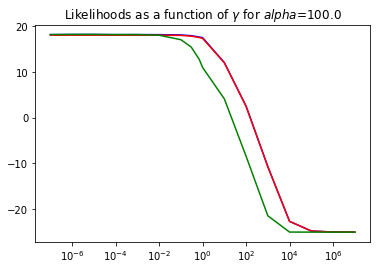

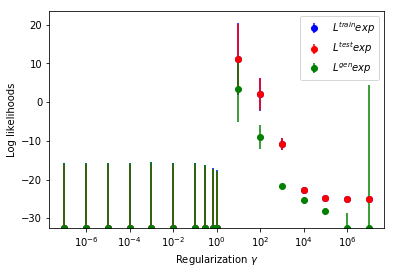

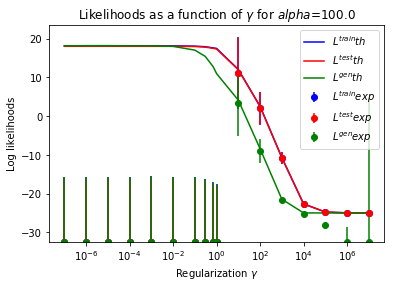

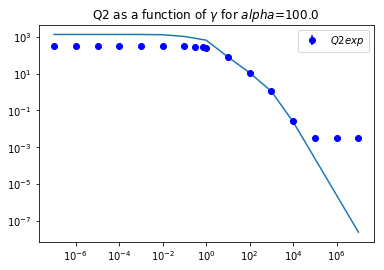

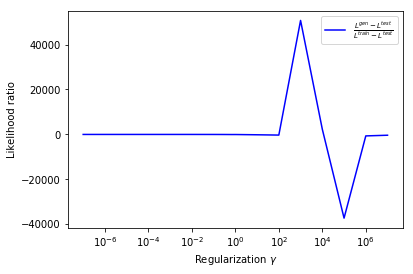

In [20]:
plot_likelihoods(base_exp='176492489e216d96', n_l=0, n_r=0)

In [127]:
def experiment_comparison_logZ(path='out_bidiag/', base_exp='048426a088a62f43'):
    siblings, values = get_siblings(base_exp, 'gamma', path=path)    
    with open(path+'raw/{}/params'.format(base_exp), 'r') as f:
        alpha = json.load(f)['alpha']
        
        
    siblings, values = siblings[2:], values[2:]
    print('Working with alpha = {}'.format(alpha))
    logZ_exp_mean = []
    logZ_exp_std = []
    logZ_the = []
    
    Q2_exp_mean = []
    Q2_exp_std = []
    Q2_the = []
    
    for folder, gamma in zip(siblings, values):
        print('Experiment with hash {} : gamma= {}'.format(folder, gamma))
#         logZ_exp_mean.append(np.load(path+'raw/{}/logZ_avg.npy'.format(folder))[-100:].mean())
#         logZ_exp_std.append(np.load(path+'raw/{}/logZ_std.npy'.format(folder))[-100:].mean())
        
        plop = compute_likelihoods(model_to_fit, alpha, gamma)[-2:]
    
        logZ_exp_mean.append(np.load(path+'raw/{}/logZ.npy'.format(folder))[:, -100:].mean())
        logZ_exp_std.append(np.load(path+'raw/{}/logZ.npy'.format(folder))[:, -100:].std())
        logZ_the.append(plop[0])
        print('LogZ Experiment : {} pm {}, theory : {}'.format(logZ_exp_mean[-1], logZ_exp_std[-1], logZ_the[-1]))
        
        Q2_exp_mean.append(np.load(path+'raw/{}/Q2.npy'.format(folder))[:, -100:].mean())
        Q2_exp_std.append(np.load(path+'raw/{}/Q2.npy'.format(folder))[:, -100:].std())
        Q2_the.append(plop[1])
        print('Q2 Experiment: {} pm {}, theory : {}'.format(Q2_exp_mean[-1], Q2_exp_std[-1], Q2_the[-1]))
        print('{} pm {}'.format(Q2_exp_mean[-1] / Q2_the[-1], Q2_exp_std[-1] / Q2_the[-1]))
        
    plt.figure()
    plt.errorbar(values, logZ_exp_mean, yerr=logZ_exp_std, label='Experiment')
    plt.errorbar(values, logZ_the, label='Theory')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel(r'LogZ')
    plt.legend()
    plt.title(r'$logZ(\gamma)$ for fixed $\alpha$={}'.format(alpha))
    plt.show()
    
    plt.figure()
    plt.errorbar(values, Q2_exp_mean, yerr=Q2_exp_std, label='Experiment')
    plt.errorbar(values, Q2_the, label='Theory')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel(r'Q2')
    plt.legend()
    plt.title(r'$Q2(\gamma)$ for fixed $\alpha$={}'.format(alpha))
    plt.show()


def experiment_comparison_mu(path='out_bidiag/', base_exp='048426a088a62f43'):
    siblings, values = get_siblings(base_exp, 'gamma', path=path)    
    with open(path+'raw/{}/params'.format(base_exp), 'r') as f:
        alpha = json.load(f)['alpha']
    
    print('Working with alpha = {}'.format(alpha))
    
    mu_exp_mean = []
    mu_exp_std = []
    mu_the = []
    
    for folder, gamma in zip(siblings, values):
        print('Experiment with hash {} : gamma= {}'.format(folder, gamma))
        mu_exp_mean.append(np.load(path+'raw/{}/mus.npy'.format(folder))[:, -100:].mean())
        mu_exp_std.append(np.load(path+'raw/{}/mus.npy'.format(folder))[:, -100:].std())
        
#         mu_exp_mean.append(np.load(path+'raw/{}/mu_avg.npy'.format(folder))[-100:].mean())
#         mu_exp_std.append(np.load(path+'raw/{}/mu_std.npy'.format(folder))[-100:].mean())
        
        mu_the.append(1)#solve_mu(model_to_fit, alpha, gamma))
        print('Experiment : {} pm {}, theory : {}'.format(mu_exp_mean[-1], mu_exp_std[-1], mu_the[-1]))
        
    plt.figure()
    plt.errorbar(values, mu_exp_mean, yerr=mu_exp_std, label='Experiment')
    plt.errorbar(values, mu_the, label='Theory')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'Regularization $\gamma$')
    plt.ylabel(r'Lagrange multiplier $\mu$')
    plt.legend()
    plt.title(r'$\mu(\gamma)$ for fixed $\alpha$={}'.format(alpha))
    plt.show()

